In [11]:
import torch.nn as nn
import torch 
from CycleGAN1 import Generator , get_memory_loader 
import matplotlib.pyplot as plt
import numpy as np 

def load_for_inference(checkpoint_path, input_shape=(2, 128, 128)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize the specific generator you want (usually A -> B)
    model = Generator(input_shape).to(device)
    
    # Load the file
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Extract only the Generator state
    # Note: Ensure the key matches what you saved ('G_AB' or 'G_BA')
    if 'G_AB' in checkpoint:
        model.load_state_dict(checkpoint['G_AB'])
    else:
        # Fallback if you saved the whole model directly instead of a dict
        model.load_state_dict(checkpoint)
        
    model.eval() # Set to evaluation mode (turns off Dropout/Norm update)
    print("Generator loaded successfully for inference.")
    
    return model



In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Usage:
G_AB = load_for_inference("/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/new_experiment/checkpoint_epoch_30.pth")
G_AB.eval()
fileA= '/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/fileA_test.pt'
fileB= '/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/fileB_test.pt'
dataloader = get_memory_loader(fileA, fileB , batch_size=4) 



Generator loaded successfully for inference.
Loading tensors...


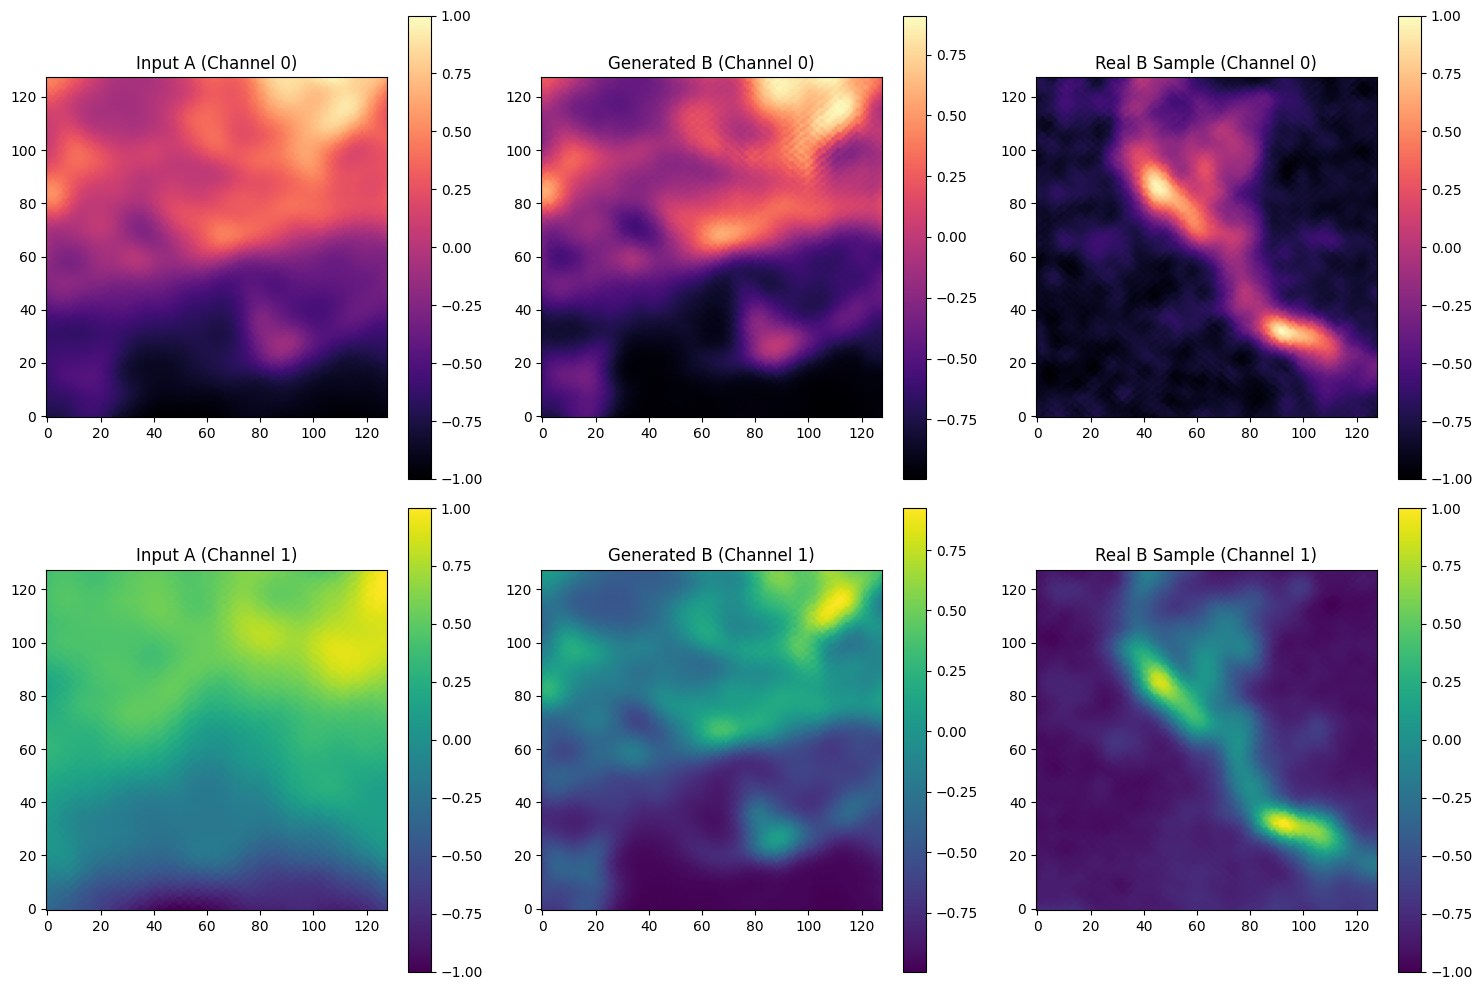

In [15]:
# 2. Run Inference
# Use no_grad to save memory and computations
with torch.no_grad():
    for i, batch in enumerate(dataloader):
        real_A = batch['A'].to(device)
        
        # Generate Fake B
        fake_B_tensor = G_AB(real_A)
        
        # Move to CPU and Numpy
        # .detach() is required to remove it from the computation graph
        real_A_np = real_A.cpu().detach().numpy()
        fake_B_np = fake_B_tensor.cpu().detach().numpy()
        real_B_np = batch['B'].numpy() # This is likely random B, not paired B (CycleGAN nature)
        
        # Stop after one batch for plotting
        break 

# 3. Plotting Logic (for 2-Channel Data)
# We will plot the first image in the batch (index 0)
idx = 0 

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# --- Channel 0 (e.g., Density/Flux) ---
# Input A
im1 = axes[0, 0].imshow(real_A_np[idx, 0, :, :], cmap='magma', origin='lower')
axes[0, 0].set_title("Input A (Channel 0)")
plt.colorbar(im1, ax=axes[0, 0])

# Generated B
im2 = axes[0, 1].imshow(fake_B_np[idx, 0, :, :], cmap='magma', origin='lower')
axes[0, 1].set_title("Generated B (Channel 0)")
plt.colorbar(im2, ax=axes[0, 1])

# Real B (Random Sample from Domain B)
im3 = axes[0, 2].imshow(real_B_np[idx, 0, :, :], cmap='magma', origin='lower')
axes[0, 2].set_title("Real B Sample (Channel 0)")
plt.colorbar(im3, ax=axes[0, 2])

# --- Channel 1 (e.g., Velocity/Temperature) ---
# Input A
im4 = axes[1, 0].imshow(real_A_np[idx, 1, :, :], cmap='viridis', origin='lower')
axes[1, 0].set_title("Input A (Channel 1)")
plt.colorbar(im4, ax=axes[1, 0])

# Generated B
im5 = axes[1, 1].imshow(fake_B_np[idx, 1, :, :], cmap='viridis', origin='lower')
axes[1, 1].set_title("Generated B (Channel 1)")
plt.colorbar(im5, ax=axes[1, 1])

# Real B
im6 = axes[1, 2].imshow(real_B_np[idx, 1, :, :], cmap='viridis', origin='lower')
axes[1, 2].set_title("Real B Sample (Channel 1)")
plt.colorbar(im6, ax=axes[1, 2])

plt.tight_layout()